In [43]:
# AWS IonQ Demo - Adding with Atoms two digit binary addition

In [44]:
# by Alex Khan 

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

In [3]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-amazon-braket-hu-demo" # the name of the bucket
my_prefix = "results" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [4]:
# print all (the usual suspects) available gates currently available within SDK
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print('Gate set supported by SDK:\n', gate_set)
print('\n') 

# the IonQ device
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the IonQ device:\n', supported_gates)

Gate set supported by SDK:
 ['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CY', 'CZ', 'H', 'I', 'ISwap', 'PSwap', 'PhaseShift', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


Gate set supported by the IonQ device:
 ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap', 'i']


In [48]:
# Test using the local simulator
device = LocalSimulator()

2 bit adder circuit
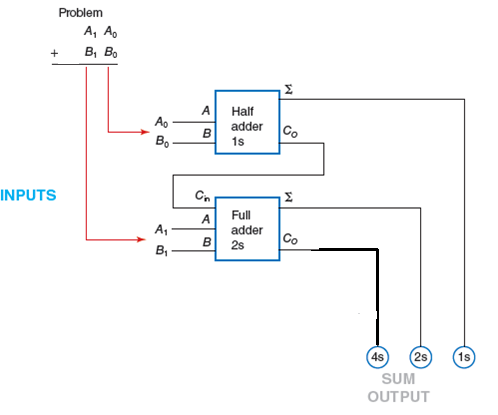

The first section is the half adder, and then the next is the full adders.  Input is on the first 4 qubits, while output is read off the last three qubits.  This circuit can take two 2 digit binary numbers and add them up.

We are only going to build a 2 bit adder since it requires 9 qubits. The 3 bit adder requires 13 qubits and is not possible on the 11 qubit system.

In [49]:
# input portion of the circuit takes '10', '10' and uses x gates to set up qubit initial state to 1

def inputcircuit(input1,input2):
    inputcircuit=Circuit()
    if (input1[1]=='1'):
        inputcircuit.x(0)
    if(input2[1]=='1'):
        inputcircuit.x(1)
    if(input1[0]=='1'):    
        inputcircuit.x(2)
    if(input2[0]=='1'):
        inputcircuit.x(3)
    
    
    return(inputcircuit)

In [233]:
# we can define a toffoli gate in different ways, but here is a circuit implementation

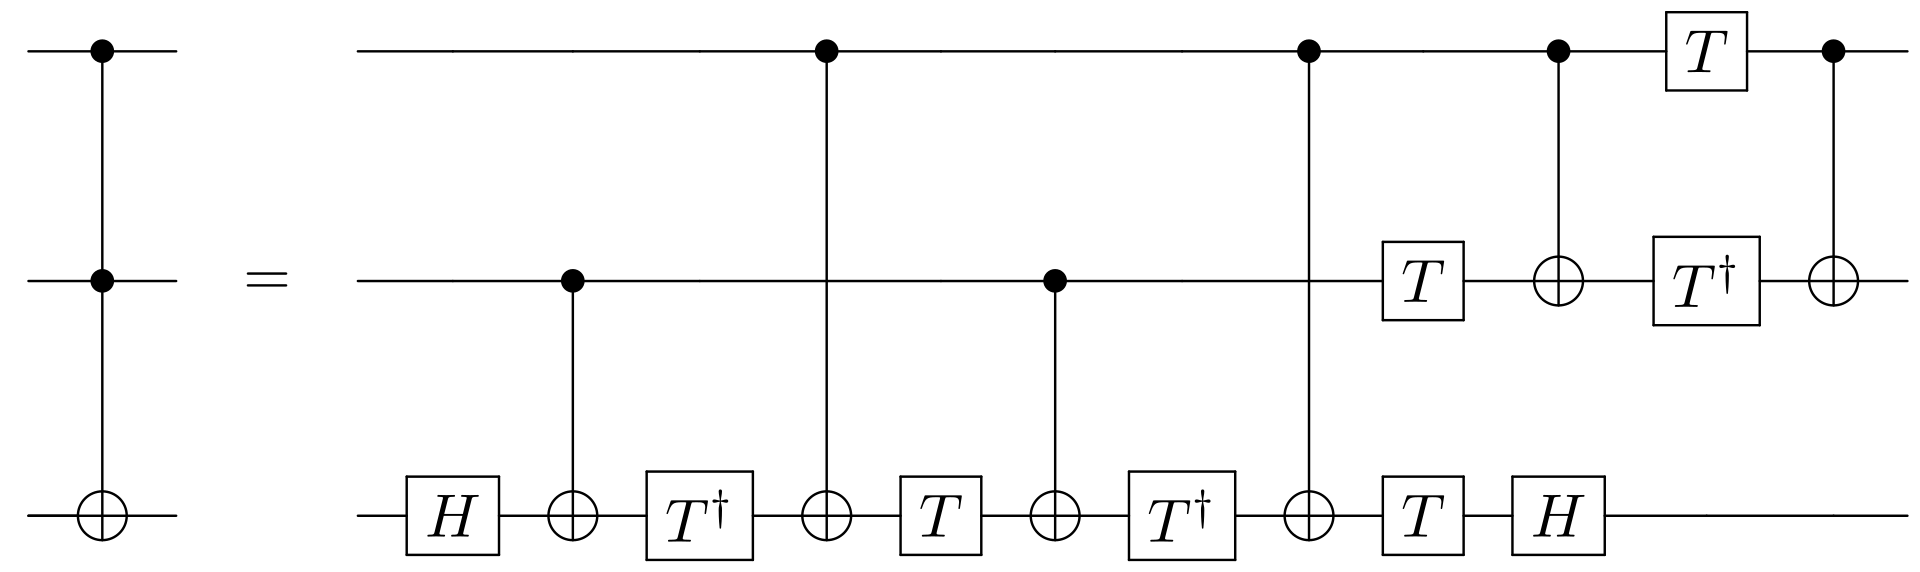

In [50]:
# Toffoli gate 

def tof(c0,c1,t):
    toffoli = Circuit().h(t).cnot(c1,t).ti(t).cnot(c0,t).t(t).cnot(c1,t).ti(t).cnot(c0,t).t(c1).t(t).cnot(c0,c1).h(t).t(c0).ti(c1).cnot(c0,c1)
    return(toffoli)

In [51]:
# The full two bit adder circuit

def addercircuit():
    # half adder 
    addercircuit=Circuit().cnot(0,6).cnot(1,6).add_circuit(tof(0,1,4))
    # full adder
    addercircuit=addercircuit.cnot(2,5).cnot(4,7).cnot(3,5).cnot(5,7).add_circuit(tof(2,3,8)).add_circuit(tof(2,4,8)).add_circuit(tof(3,4,8))
    
    
    return(addercircuit)

In [52]:
# add function that takes the two 3-bit input values and creates the circuit that will be executed on the quantum device

def add(a,b):
    ic=inputcircuit(a,b)
    ac=addercircuit()
    
    final_circuit=ic.add_circuit(ac)
    return(final_circuit)
    

In [53]:
# user can input the two binary numbers below

In [82]:
a='11'
b='11'
add_circuit=add(a,b)

In [83]:
#print(add_circuit)

11 + 11 simulator answer


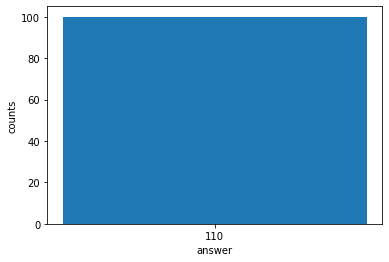

In [84]:
# run circuit on simulator
device = LocalSimulator()
result = device.run(add_circuit, shots=100).result()
# get measurement shots
counts = result.measurement_counts
my_sum=""
answer=[]
quantity=[]
for i in range (len(counts.keys())):
    my_sum=""
    for j in range(8,5, -1):
        my_sum+=(list(counts.keys())[i][j])
    answer.append(my_sum)
    quantity.append(list(counts.values())[i])
print(a,'+', b, "simulator answer")
plt.bar(answer, quantity);
plt.xlabel('answer');
plt.ylabel('counts');

In [85]:
# Below we will run the circuit on the physical ion trap (IonQ)
   

In [86]:
ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

In [87]:
# run circuit with a polling time of 5 days
ionq_task = ionq.run(add_circuit, s3_folder, shots=100, poll_timeout_seconds=5*24*60*60)

# get id and status of submitted task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()
# print('ID of task:', ionq_task_id)
print('Status of task:', ionq_status)

Status of task: CREATED


In [24]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) task:', status)
print(ionq_task_id)

In [15]:
def recover_task_sum(task_id,a,b):
    # recover task
    task_load = AwsQuantumTask(arn=task_id)

    # print status
    status = task_load.state()
    #print('Status of (reconstructed) task:', status)

    # wait for job to complete
    # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
    if status == 'COMPLETED':
        # get results
        results = task_load.result()
        # print(rigetti_results)

        # get all metadata of submitted task
        metadata = task_load.metadata()
        # example for metadata
        shots = metadata['shots']
        machine = metadata['deviceArn']
        # print example metadata
        print("{} shots taken on machine {}.".format(shots, machine))

        # get measurement counts
        counts = results.measurement_counts
        #print('Measurement counts:', counts)
        
        #Note: this code ensures the input qubits are in the correct values 
        inmask=['0','0','0','0']
        
        if(a[1]=='1'):
            inmask[0]='1'
        if(b[1]=='1'):
            inmask[1]='1'
        if(a[0]=='1'):    
            inmask[2]='1'
        if(b[0]=='1'):
            inmask[3]='1'
        inmask=''.join(inmask)
        #print(inmask)
        
        my_sum=""
        answer=[]
        quantity=[]
        #rint(len(counts.keys()))
        
        # Find the output string (qubits 6,7,8) reverse it if the input portion is still correct
        # Note: I am not matching the middle two qubits (4,5) which might have errored out as well
        
        for i in range (len(counts.keys())):
            my_sum=""
            my_input=""
            for k in range(0,4):
                my_input+=(list(counts.keys()))[i][k] 
            if (inmask==my_input):
                for j in range(8,5, -1):
                    my_sum+=(list(counts.keys())[i][j])
                answer.append(my_sum)
                quantity.append(list(counts.values())[i])
            
        # Plot only the correct values from the full result set
        
        #print(answer)
        #print(quantity)
        print(a,'+', b, "IonQ answer")
        plt.bar(answer, quantity);
        plt.xlabel('answer');
        plt.ylabel('counts');
        
       

    elif status in ['FAILED', 'CANCELLED']:
        # print terminal message 
        print('Your task is in terminal status, but has not completed.')

    else:
        # print current status
        print('Sorry, your task is still being processed and has not been finalized yet.')

10 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.
10 + 01 IonQ answer


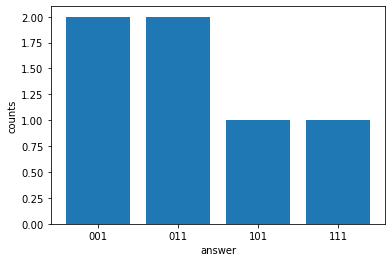

In [16]:
recover_task_sum('','10','01')

10 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.
10 + 01 IonQ answer


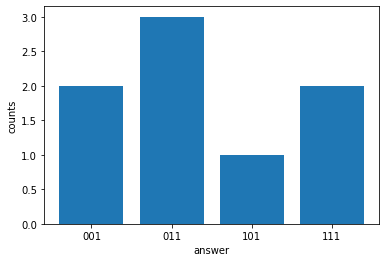

In [17]:
recover_task_sum('','10','01')

10 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.
11 + 11 IonQ answer


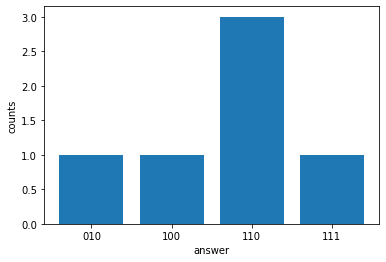

In [18]:
recover_task_sum('', '11', '11')

100 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.
01 + 01 IonQ answer


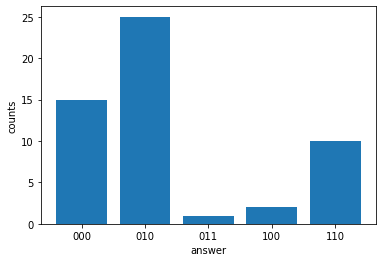

In [19]:
recover_task_sum('', '01', '01')

100 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.
11 + 01 IonQ answer


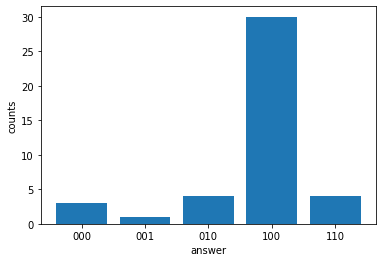

In [20]:
recover_task_sum('', '11', '01')

100 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.
10 + 11 IonQ answer


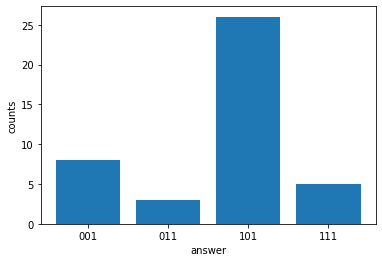

In [21]:
recover_task_sum('', '10', '11')

100 shots taken on machine arn:aws:braket:::device/qpu/ionq/ionQdevice.
11 + 11 IonQ answer


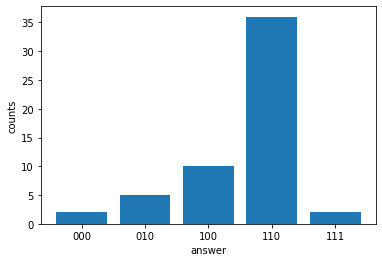

In [22]:
recover_task_sum('', '11', '11')